In [1]:
from tqdm import tqdm
from pit30m import LogReader
import glob
import numpy as np
from uuid import UUID
import lz4

from pit30m.data.partitions import PreProcessPartition
from pit30m.camera import CamName

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# with open("../pit30m/all_logs.txt", "r") as f:
#     logs = f.readlines()
#     logs = [x.strip() for x in logs]

logs = []
for f in glob.glob("/home/julieta/pit30m_partitions/utm_poses_dense/to_hide/*"):
    logs.append(f.split("/")[-1][:-4])
    
print(logs)

['556af30b-cb04-4a08-ee47-4eb9e79da376', '97aa90fa-2886-4442-e287-1b587055cc1f', '5a4990e9-f731-4990-cf64-47f778511434', '73bb2204-9439-4345-ea30-ce12ecaf849e', 'e9328cc6-bcf3-4a7b-c2d6-31764842f25a', '3081609a-d65e-48b3-d1a9-7ce3493379da', '261b832e-5144-4b9b-ed18-a574f5cbb3a0', '8dcbcf17-83e5-4286-fa13-6a307f88ffc1', 'e4be10b1-9449-410d-c780-8e55d5a7a230', 'b2f1671a-15da-4079-f1fb-7eba857588d5', '60ef8b47-dea9-47de-f564-2c69a809e3b7', '07160994-465c-488e-c835-263b472eed59', '634c69be-a334-43c9-d1be-19b59d70469e', '622f2be3-cf6a-4f8d-d476-064a7854763b', 'e00f58cc-20ee-47e6-c02c-d71311d06e60', 'f143ac17-13fd-4c00-d647-938c5c5a4731', '5911ed8a-c4cb-43c9-ce47-51df553aa7d4', '73570e6a-ae36-4919-e045-2861a63b7108', '43f9a617-ff72-4ed2-dcfd-d016dfd365c3', 'd7385a30-a744-49e7-d897-43ec8b4b550b', 'e0243a14-d18e-4759-c26c-1b68fa71eca6', '13d203be-9937-4180-efce-929f2e036132', '7c345e3b-1f2d-491a-c203-de32a512c3ad', 'a345cd5f-4373-43ee-ee5b-f43dc9dba7cd', '1519e57a-c85d-4d64-e4d1-35c1e74236f6',

In [12]:
log_readers = {}
for logid in logs:
    log_readers[logid] = LogReader(f"s3://pit30m/{logid}/", partitions=[PreProcessPartition.VALID])

100%|██████████| 260/260 [31:33<00:00,  7.28s/it]


Total included: 58_862_554


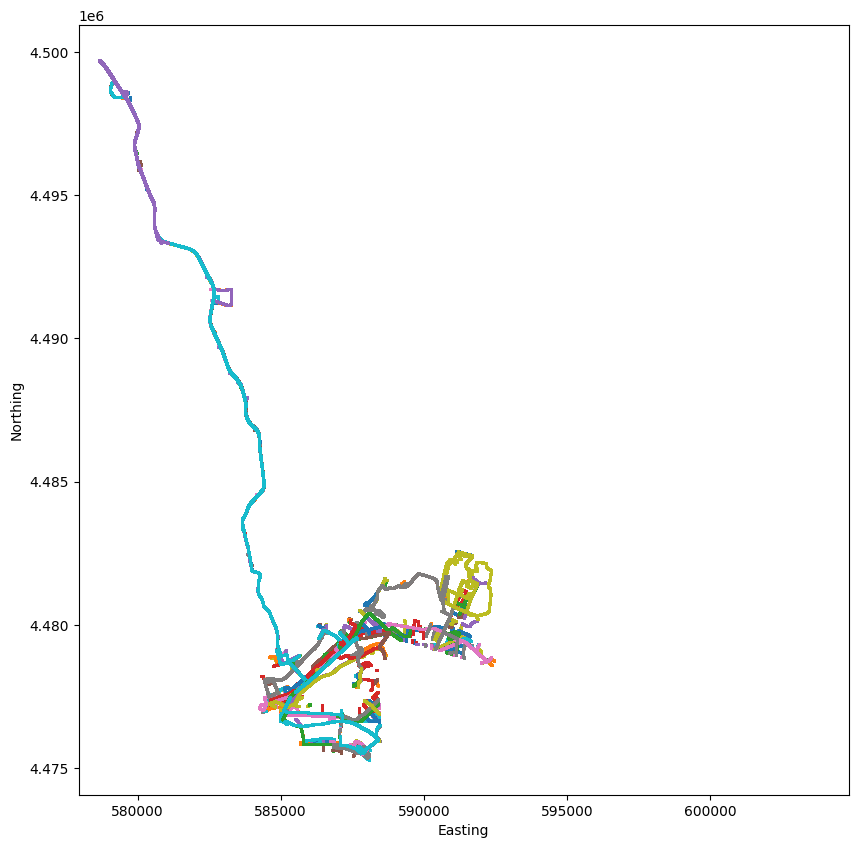

In [13]:
figsz = 20 // 2
fig = plt.figure(figsize=(figsz, figsz), dpi=100, facecolor='w', edgecolor='k')

included = 0
for log_id, lr in tqdm(log_readers.items()):
    
    hidden_in_log = 0
    # index = lr.get_cam_geo_index(CamName.MIDDLE_FRONT_WIDE)
    # index = lr.map_relative_poses_dense
    valid, index = lr.utm_poses_dense
    # print(index)
    index = index[valid]
    # break
    
    # x = index["utm_x"]
    # y = index["utm_y"]
    x, y = index[:, 0], index[:, 1]
    sc = plt.scatter(x, y, s=0.5, alpha=0.5)
    
    included += len(x)
    
    # percent_hidden = 100 * hidden_in_log / len(utm)
    # if percent_hidden > 90: 
    #     print(f"{log_id} has {hidden_in_log:_} poses to hide ({percent_hidden:.2f}%)")

plt.axis("square")
plt.xlabel("Easting")
plt.ylabel("Northing")
print(f"Total included: {included:_}")

In [ ]:
submap_ids = sorted([UUID(bytes=x.ljust(16, b"\x00")) for x in np.unique(index["submap_id"])])
print(len(submap_ids))
print(submap_ids[:10])

124
[UUID('00000000-0000-0000-0000-000000000000'), UUID('00a53038-3072-4115-f458-02769036233f'), UUID('02c07a67-6925-4d5e-c4e4-3a65b1e37b94'), UUID('07e78e05-8aba-421f-e1e4-27679cec69a7'), UUID('082c2a5a-7516-4f9e-fce0-6ab6eb3e0965'), UUID('0c40dc7d-1d68-4482-d48a-d3c71ff26ca4'), UUID('0cd730f5-08b5-4a91-e5c2-077134e3cb61'), UUID('0d864017-a690-4255-c225-551e3c48705f'), UUID('12e48274-21e0-4340-d3fa-101b21a1baab'), UUID('17b09d4c-2514-43c8-f3e3-8133a4ebc62e')]


In [ ]:
from typing import Iterable
from pathlib import Path
from joblib import Parallel, delayed
import pickle
from numpy.lib import recfunctions as rfn

def get_utm_poses_with_metadata(lr):
    pose_time, pose_valid, pose_xy = lr.utm_poses_dense
    time = rfn.unstructured_to_structured(pose_time[:, np.newaxis], names=["utm_time"])
    # assert np.all(np.diff(time["utm_time"]) >= 0), "Pose times are not sorted"
    valid = rfn.unstructured_to_structured(pose_valid[:, np.newaxis], names=["utm_valid"])
    # assert len(valid) == len(pose_valid)
    xys = rfn.unstructured_to_structured(pose_xy, names=["utm_x", "utm_y"])
    # assert len(xys) == len(pose_xy)
    sensor_poses = rfn.merge_arrays([time, valid, xys], flatten=True)

    return lr.log_id, sensor_poses

def get_utm_dense_poses(
    logs: Iterable[UUID],
    logreader_path: Path = Path("/mnt/data/pit30m/pose-backup-2023-04-18/"),
    # logreader_path: Path = Path("/mnt/data/pit30m/pose-backup-2023-04-18/"),
    pool: Parallel = None,
    pickled: bool = None,
):
    """Multiple ways to get dense poses
    Args:
        logs: list of log ids whose dense poses we want to load
        logreader_path: Path where to load log readers from
        pool: pool of parallel workers to load the poses
        pickled: whether to load from a pre-dumped pickled file on disk
    """

    log_readers = [LogReader(str(logreader_path / f"{log}")) for log in logs]

    if pickled:
        # If loading from pickle, ignore everything and just load from disk
        with open("/home/julieta/pickles/utm_dense_poses.pkl", "rb") as handle:
            sensor_poses = pickle.load(handle)

        # The pickle has everything -- filter for the ones that were asked for
        sensor_poses = {log_id: sensor_pose for (log_id, sensor_pose) in sensor_poses.items() if log_id in logs}
    else:
        if pool:
            res = pool(delayed(get_utm_poses_with_metadata)(lr) for lr in log_readers)
            sensor_poses = {log_id: index for (log_id, index) in res}
        else:
            sensor_poses = {
                log_id: get_utm_poses_with_metadata(lr)[1]
                for (log_id, lr) in tqdm(
                    zip(logs, log_readers), total=len(logs), desc="Getting dense poses sequentially from disk"
                )
            }

    log_readers = {log_id: lr for (log_id, lr) in zip(logs, log_readers)}
    return sensor_poses, log_readers, pool


In [ ]:
pose_fpath = "/mnt/data/pit30m/pose-backup-2023-04-18/556af30b-cb04-4a08-ee47-4eb9e79da376/all_poses.npz.lz4"

In [ ]:
with open(pose_fpath, "rb") as in_compressed_f:
    with lz4.frame.open(in_compressed_f, "rb") as wgs84_f:
        poses = np.load(wgs84_f)["data"]

In [ ]:
submap_ids = sorted([UUID(bytes=x.ljust(16, b"\x00")) for x in np.unique(poses["map_relative"]["submap"])])
print(len(submap_ids))
print(submap_ids[:10])

136
[UUID('00a53038-3072-4115-f458-02769036233f'), UUID('02c07a67-6925-4d5e-c4e4-3a65b1e37b94'), UUID('07e78e05-8aba-421f-e1e4-27679cec69a7'), UUID('082c2a5a-7516-4f9e-fce0-6ab6eb3e0965'), UUID('0c40dc7d-1d68-4482-d48a-d3c71ff26ca4'), UUID('0cd730f5-08b5-4a91-e5c2-077134e3cb61'), UUID('0d864017-a690-4255-c225-551e3c48705f'), UUID('116570b4-6598-4c1a-da4f-948194f9d04b'), UUID('12e48274-21e0-4340-d3fa-101b21a1baab'), UUID('17b09d4c-2514-43c8-f3e3-8133a4ebc62e')]
